In [95]:
import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.special as ss
import scipy.integrate as si
import scipy.optimize as so
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.numpy.linalg as jnl
jax.config.update("jax_enable_x64", True)

In [96]:
# size of spatial domain
a = 10.0

# set number of real space grid points for plotting
numx = 1025
# spatial grid for the purposes of plotting
xvec = np.linspace(-a, a, numx)

# set number of Fourier basis functions
# basis functions will be N = -numfour to N = numfour
numfour = 32

# matrix for converting Fourier basis coefficients
# to real space values
fourNvec = np.arange(-numfour, numfour + 1)
fourtox = np.exp(1j * np.pi * np.outer(fourNvec, xvec) / a) / np.sqrt(2 * a)

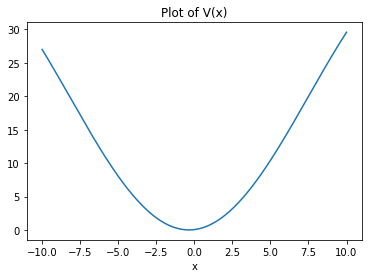

In [97]:
# define potential for generating training data

def v(z):
    # harmonic oscillator potential (should be exact for Chebyshev)
    # return 0.5 * z**2
    # symmetric double well potential
    # return 2.5e-3 * (z**2 - 25)**2
    # asymmetric double well potential
    # c0 = 4.35; c1 = 9.40e-1; c2 = -3.56e-1; c3 = -4.66e-2
    # c4 = 1.46e-2; c5 = 6.76e-4; c6 = -1.26e-4; c7 = -5.43e-6
    # c8 = 4.12e-7; c9 = 1.65e-8
    # x = z + 0.8
    # return 0.5 * (c0 + c1*x + c2*x**2 + c3*x**3 + c4*x**4 + c5*x**5 \
    #        + c6*x**6 + c7*x**7 + c8*x**8 + c9*x**9)
    # non-polynomial potentials
    return 20 * (1 + np.sin(0.2 * z - 1.5))
    # return 15 * (-np.cos(z) + np.sin((0.5 * z)**2 - 0.2 * z))
    # soft coulomb potential
    # return -1 / np.sqrt(z**2 + 0.25)


# compute true potential on real space grid for plotting
vxvec = v(xvec)

# plot true potential
plt.plot(xvec, vxvec)
plt.title('Plot of V(x)')
plt.xlabel('x')
plt.show()

In [98]:
# transform real space potential to Fourier
# representation using quadrature method
# (in tdse-adj-cheb-fft-vs-quad-kbc.ipynb we show that
# the quadrature method produces much more accurate
# results than the FFT method)

vtoeprow = []
for thisN in range(2 * numfour +1):
    def intgrnd(x):
        return v(x) * np.exp(-1j * np.pi * thisN * x / a) / (2 * a)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    vtoeprow.append(si.quad(rintgrnd, -a, a)[0] + 1j * si.quad(iintgrnd, -a, a)[0])
vtoeprow = np.array(vtoeprow)
fourvmat = sl.toeplitz(r=vtoeprow, c=vtoeprow.conj())

print('Shape fourvmat:', fourvmat.shape)

Shape fourvmat: (65, 65)


Vector L2 Error psi0_0: 4.072507283500841e-06
Vector L-infinity Error psi0_0: 1.8301527573114097e-06
Vector L2 Error psi0_1: 4.072507283500477e-06
Vector L-infinity Error psi0_1: 1.8301527573114097e-06
Vector L2 Error psi0_2: 7.817152418851509e-12
Vector L-infinity Error psi0_2: 4.1810999107383395e-13


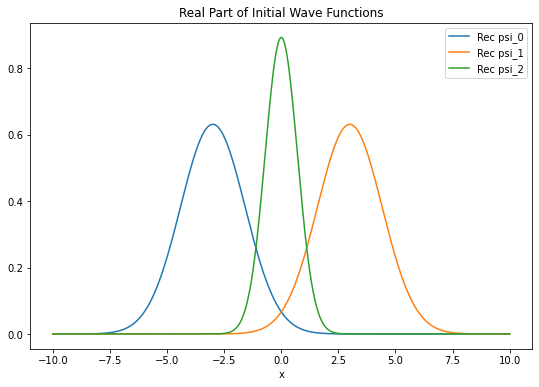

In [99]:
# define initial states and transform to Fourier basis

def psi0_0(x):
    return np.exp(-(x + 3)**2 / 4) * (2.0 / np.pi)**0.25

def psi0_1(x):
    return np.exp(-(x - 3)**2 / 4) * (2.0 / np.pi)**0.25

def psi0_2(x):
    return np.exp(-(x - 6)**2) * (2.0 / np.pi)**0.25

def psi0_3(x):
    return np.exp(-(x + 6)**2) * (2.0 / np.pi)**0.25

def psi0_4(x):
    return np.exp(-x**2) * (2.0 / np.pi)**0.25

def mka0(psi0fn):
    # compute psi0 normalization term
    psi0fn_prob_intgrnd = lambda x: np.abs(psi0fn(x)) ** 2
    psi0fn_norm = np.sqrt(si.quad(psi0fn_prob_intgrnd, -a, a)[0])

    # normalized psi function (for integration)
    norm_psi0fn_fn = lambda x: psi0fn(x) / psi0fn_norm

    # compute the Fourier representation of psi0fn
    norm_psi0fn = []
    for thisfourn in range (numfour + 1):
        def intgrnd(x):
            return norm_psi0fn_fn(x) * np.exp(-1j * np.pi * thisfourn * x / a) / np.sqrt(2 * a)
        def rintgrnd(x):
            return intgrnd(x).real
        def iintgrnd(x):
            return intgrnd(x).imag
        norm_psi0fn.append(si.quad(rintgrnd, -a, a)[0] \
                           + 1j * si.quad(iintgrnd, -a, a)[0])

    a0 = np.concatenate([np.conjugate(np.flipud(norm_psi0fn[1:])), norm_psi0fn])

    normpsi0x = norm_psi0fn_fn(xvec)

    return a0, normpsi0x

psi0fnvec = [psi0_0, psi0_1, psi0_4]

a0vec = []
normpsi0xvec = []
normpsi0recxvec = []
for thispsi0fn in psi0fnvec:
    tempa0, tempnormpsi0x = mka0(thispsi0fn)
    a0vec.append(tempa0)
    normpsi0xvec.append(tempnormpsi0x)
    normpsi0recxvec.append(tempa0 @ fourtox)


# plot the real part of the normalized psi0
plt.figure(figsize=(9, 6))
for i in range(len(normpsi0xvec)):
    print(f'Vector L2 Error psi0_{i}:', nl.norm(normpsi0xvec[i] - normpsi0recxvec[i]))
    print(f'Vector L-infinity Error psi0_{i}:', np.max(np.abs(normpsi0xvec[i] - normpsi0recxvec[i])))
    # plt.plot(xvec, normpsi0xvec[i].real, label=f"Truth {i}")
    plt.plot(xvec, normpsi0recxvec[i].real, label=f"Rec psi_{i}")

plt.title('Real Part of Initial Wave Functions')
plt.xlabel('x')
plt.legend()
plt.show()

In [100]:
# solve the forward TDSE problem in the Fourier
# representation

# set time-step size
dt = 1e-2

# set number of time-steps
# size of trajectory = numts + 1
numts = 100

# kinetic operator in the Fourier representation
kmat = np.diag(np.arange(-numfour, numfour + 1)**2 * np.pi**2 / (2 * a**2))

# Hamiltonian operator in the Fourier representation
fourHmat = kmat + fourvmat

# check if the Hamiltonian matrix is Hermitian
print('fourHmat Hermitian check (should be close to zero):', nl.norm(fourHmat - fourHmat.T.conj()), sep='\n')

# eigen-decomposition of the Hamiltonian matrix
fourspc, fourstt = nl.eigh(fourHmat)

# check if eigendecomposition diagonalizes the
# Hamiltonian matrix
# if result is close to zero then
# fourHmat = fourstt @ np.diag(fourspc) @ np.conj(fourstt).T
print('Check if hmat is diagonalized (should be close to zero):', nl.norm(fourHmat @ fourstt - fourstt @ np.diag(fourspc)), sep='\n')

# check if eigenstates are unitary
print('Check if fourstt is unitary (should be close to zero):', nl.norm(fourstt @ fourstt.T.conj() - np.eye(2 * numfour + 1)), sep='\n')

# compute propagator matrix
fourpropa = fourstt @ np.diag(np.exp(-1j * fourspc * dt)) @ fourstt.conj().T

fouramatvec = []

# propagate "a" state
for thisa0 in a0vec:
    tempfouramat = np.zeros((numts + 1, 2 * numfour + 1), dtype=np.complex128)
    tempfouramat[0] = thisa0.copy()
    for i in range(numts):
        tempfouramat[i + 1] = fourpropa @ tempfouramat[i]
    fouramatvec.append(tempfouramat)

jaxfouramatvec = jnp.stack(fouramatvec)

print('Done propagating')
print('Shape jaxfouramatvec:', jaxfouramatvec.shape)

fourHmat Hermitian check (should be close to zero):
0.0
Check if hmat is diagonalized (should be close to zero):
3.1570757488486376e-13
Check if fourstt is unitary (should be close to zero):
1.175656623858967e-14
Done propagating
Shape jaxfouramatvec: (3, 101, 65)


In [101]:
# Jax compliant method for making a toeplitz matrix

numtoepelm = 2 * numfour + 1
aa = (-1) * np.arange(0, numtoepelm).reshape(numtoepelm, 1)
bb = [np.arange(numtoepelm - 1, 2 * numtoepelm -1)]
toepindxmat = jnp.array(aa + bb)
print(toepindxmat.shape)

(65, 65)


In [102]:
# Chebyshev Representation

# set number of Chebyshev basis functions
# I have found odd numbers work best
numcheb = 15  # 11 # 15

# compute Chebyshev coefficients for true potential
def theta(k):
    return (k - 0.5) * np.pi / (numcheb + 1)

def g(k):
    return v(a * np.cos(theta(k)))

chebkvec = np.arange(1, numcheb + 2)
chebnvec = np.arange(0, numcheb + 1)

chebweights = np.ones(numcheb + 1)
chebweights[0] = 0.5

chebvcff = 2 / (numcheb + 1) * np.sum(g(chebkvec) * np.cos(chebnvec[..., np.newaxis] * theta(chebkvec)), axis=1)

chebvcff = chebweights * chebvcff

print('chebvcff:', chebvcff, sep='\n')

# matrix for converting cheb to real space
chebtox = ss.eval_chebyt(np.expand_dims(chebnvec, 0), np.expand_dims(xvec / a, 1))

# matrix for converting cheb to four
chebtofour = []

for thiscn in range(numcheb + 1):
    temptoeprow = []
    # convert cheb basis function to four representation
    for thisn in range(2 * numfour + 1):
        def intgrnd(x):
            return ss.eval_chebyt(thiscn, x / a) * np.exp(-1j * np.pi * thisn * x / a) / (2 * a)

        def rintgrnd(x):
            return intgrnd(x).real

        def iintgrnd(x):
            return intgrnd(x).imag

        temptoeprow.append(si.quad(rintgrnd, -a, a)[0] + 1j * si.quad(iintgrnd, -a, a)[0])
    chebtofour.append(sl.toeplitz(r=temptoeprow, c=np.conj(temptoeprow)))

jaxchebtofour = jnp.transpose(np.array(chebtofour), [1, 2, 0])

print('Shape chebtoF:', jaxchebtofour.shape)

chebvcff:
[ 1.55334014e+01  1.63183596e+00  1.40780070e+01 -3.64843386e-01
 -1.35642240e+00  1.99185484e-02  4.79766748e-02 -4.95002172e-04
 -8.84959688e-04  7.05205601e-06  1.00363408e-05 -6.51994576e-08
 -7.71141591e-08  4.23000301e-10  4.28080127e-10 -2.01083594e-12]
Shape chebtoF: (65, 65, 16)


In [103]:
def cobjfn(cffs):
    vhatmat = jaxchebtofour @ cffs
    # test if flipping the resulting vmat improves accuracy
    # vhatmat = jnp.flip(jaxchebtofour @ cffs)

    # construct the Hamiltonian matrix
    hhatmat = kmat + vhatmat

    # eigendecomposition of the Hamiltonian matrix
    spchat, stthat = jnl.eigh(hhatmat)

    # propagator matrix of a-vector
    propahatmat = stthat @ jnp.diag(jnp.exp(-1j * spchat * dt)) @ stthat.conj().T

    ahatmatvec = []
    # propagate the system starting from the initial "a" state
    for thisa0 in a0vec:
        tempamat = [thisa0.copy()]
        for i in range(numts):
            tempamat.append(propahatmat @ tempamat[i])
        # make python list a jax object
        ahatmatvec.append(jnp.stack(tempamat))
    # make python list a jax object
    ahatmatvec = jnp.stack(ahatmatvec)

    # compute the sum of objective functions in one line
    residue = ahatmatvec - jaxfouramatvec
    objective = jnp.sum(0.5 * jnp.real(jnp.sum(jnp.conj(residue) * residue, axis=1)))

    return objective

jitcobjfn = jax.jit(cobjfn)
print('jitcobjfn(chebvcff):', jitcobjfn(chebvcff))

jitcobjfn(chebvcff): 7.634891154377637e-23


In [104]:
def adjhelper(cffs):
    vhatmat = jaxchebtofour @ cffs
    # test if flipping the resulting vmat improves accuracy
    # vhatmat = jnp.flip(jaxchebtofour @ cffs)

    # construct the Hamiltonian matrix
    hhatmat = kmat + vhatmat

    # eigendecomposition of the Hamiltonian matrix
    spchat, stthat = jnl.eigh(hhatmat)

    # propagator matrix of a-vector
    propahatmat = stthat @ jnp.diag(jnp.exp(-1j * spchat * dt)) @ stthat.conj().T

    # propagator of adjoint state (backwards in time propagator)
    proplmat = stthat @ jnp.diag(jnp.exp(1j * spchat * dt)) @ stthat.conj().T

    ahatmatvec = []
    lmatvec = []

    # propagate the system starting from the initial "a" state
    for i in range(len(jaxfouramatvec)):
        tempamat = [a0vec[i].copy()]
        for j in range(numts):
            tempamat.append(propahatmat @ tempamat[j])
        # make python list a jax object
        ahatmatvec.append(jnp.stack(tempamat))

        # propagate the "lambda" vector of coefficients backward
        # in time, i.e., solve the adjoint problem
        templmat = [ahatmatvec[-1][numts,:] - jaxfouramatvec[i][numts,:]]
        # itr = 0 # forward evaluation of lmat
        for j in range(numts - 1, 0 - 1, -1):
            templmat.append(ahatmatvec[-1][j,:] - jaxfouramatvec[i][j] + proplmat @ templmat[numts - 1 - j] )

        # make python list a jax object
        lmatvec.append(jnp.flipud(jnp.stack(templmat)))

    # make python list a jax object
    ahatmatvec = jnp.stack(ahatmatvec)
    lmatvec = jnp.stack(lmatvec)

    offdiagmask = jnp.ones((numtoepelm, numtoepelm)) - jnp.eye(numtoepelm)
    expspec = jnp.exp(-1j * dt * spchat)
    e1, e2 = jnp.meshgrid(expspec, expspec)
    s1, s2 = jnp.meshgrid(spchat, spchat)
    denom = offdiagmask * (-1j * dt) * (s1 - s2) + jnp.eye(numtoepelm)
    mask = offdiagmask * (e1 - e2)/denom + jnp.diag(expspec)

    derivamats = jnp.einsum('ij,jkm,kl->ilm', stthat.conj().T, jaxchebtofour, stthat) * jnp.expand_dims(mask, 2)
    # print('sttshat.conj().T.shape', sttshat.conj().T.shape)
    alldmatreal = -1j * dt * jnp.einsum('ij,jkm,kl->mil', stthat, derivamats, stthat.conj().T)

    derivamats = jnp.einsum('ij,jkm,kl->ilm', stthat.conj().T, jaxchebtofour, stthat) * jnp.expand_dims(mask, 2)
    alldmatimag = -1j * dt * jnp.einsum('ij,jkm,kl->mil', stthat, derivamats, stthat.conj().T)

    alldmat = jnp.vstack([alldmatreal, alldmatimag])
    # print('Shape alldmat', alldmat.shape)

    return ahatmatvec, lmatvec, alldmat

def cgradfn(cffs):
    ahatmatvec, lmatvec, alldmat = adjhelper(cffs)
    # compute all entries of the gradient at once
    gradients = jnp.einsum('bij,ajk,bik->a', jnp.conj(lmatvec[:, 1:, :]), alldmat, ahatmatvec[:, :-1, :]).real[:numcheb + 1]
    return gradients

print('Shape cgradfn(cvec):', cgradfn(chebvcff).shape)

print('Gradients for True Chebyshev Coefficients (should be close to 0):', cgradfn(chebvcff), sep='\n')

jitcgradfn = jax.jit(cgradfn)
print('jitcgradfn(cvec):', jitcgradfn(chebvcff), sep='\n')

Shape cgradfn(cvec): (16,)
Gradients for True Chebyshev Coefficients (should be close to 0):
[ 2.95025565e-11 -4.37452595e-13 -2.51565366e-11  1.06851973e-12
  1.55873331e-11 -1.07416635e-12 -9.11122042e-12  3.70604454e-13
  1.36639219e-11  7.29502896e-13 -3.12876516e-11 -1.61221533e-12
  5.58289197e-11  1.66997574e-12 -7.58114835e-11 -6.68478463e-13]
jitcgradfn(cvec):
[ 2.92442075e-11 -4.11924702e-13 -2.49635120e-11  1.00802474e-12
  1.55422428e-11 -1.01529935e-12 -9.19136246e-12  3.44819332e-13
  1.37648562e-11  7.15998466e-13 -3.13003726e-11 -1.57965996e-12
  5.57071804e-11  1.64901343e-12 -7.55863658e-11 -6.80162897e-13]


---

In [105]:
def cunL2err(cff):
    def sqrerr(x):
        return (ss.eval_chebyt(chebnvec, x / a) @ cff - v(x))**2
    return np.sqrt(si.quad(sqrerr, -a, a, limit=300)[0])

print('Continuous L2 Error of Potential (should be close to 0):', cunL2err(chebvcff), sep='\n')

def cunLinferr(cff):
    def abserr(x):
        return np.abs(ss.eval_chebyt(chebnvec, x / a) @ cff - v(x))
    return np.max(si.quad(abserr, -a, a, limit=300)[0])

print('Continuous L-infinite Error of Potential (should be close to 0):', cunLinferr(chebvcff), sep='\n')

Continuous L2 Error of Potential (should be close to 0):
5.714896218633612e-12
Continuous L-infinite Error of Potential (should be close to 0):
2.2832532506542942e-11


---

In [106]:
initcffvec = []
itercountvec = []
learnedcffvec = []
L2errvec = []
Linfvec = []
cntL2errvec = []
cntLinfvec = []
objvalvec = []

numloop = 100

for i in range(numloop):
    initcffvec.append(np.random.default_rng().uniform(low=-5.0, high=5.0, size=numcheb + 1))

    tempresults = so.minimize(jitcobjfn, initcffvec[-1], jac=jitcgradfn, tol=1e-15, options={'maxiter': 1000, 'disp': False, 'gtol': 1e-14})

    itercountvec.append(tempresults.nit)
    if (i + 1) % 10 == 0:
        print(f'{i + 1}, Number of iterations:', itercountvec[-1])

    objvalvec.append(tempresults.fun)

    learnedcffvec.append(tempresults.x)

    L2errvec.append(nl.norm(chebtox @ learnedcffvec[-1] - vxvec))
    # print('Vector L2 Norm of Potential:', nl.norm(chebtox @ learnedcffvec[-1] - vxvec), sep='\n')

    Linfvec.append(np.max(np.abs(chebtox @ learnedcffvec[-1] - vxvec)))
    # print('Vector L-infinity Norm of Potential:', np.max(np.abs(chebtox @ learnedcffvec[-1] - vxvec)), sep='\n')

    cntL2errvec.append(cunL2err(learnedcffvec[-1]))
    cntLinfvec.append(cunLinferr(learnedcffvec[-1]))

print('Done')

10, Number of iterations: 201
20, Number of iterations: 224
30, Number of iterations: 164
40, Number of iterations: 616
50, Number of iterations: 218
60, Number of iterations: 214
70, Number of iterations: 640
80, Number of iterations: 218
90, Number of iterations: 274
100, Number of iterations: 208
Done


---
**Make Bar Charts**

Mean of iterations: 265.47
Variance of iterations: 21255.469100000006
Standard deviation of iterations: 145.7925550225388

Mean of objvalvec: 18.556683609560803
Variance of objvalvec: 1999.6477792217424
Standard deviation of objvalvec: 44.71742142858578


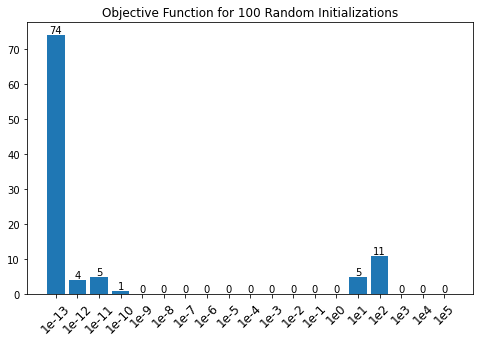

Mean of L2errvec: 87903.44562971896
Variance of L2errvec: 228304075322.25052
Standard deviation of L2errvec: 477811.7572038705


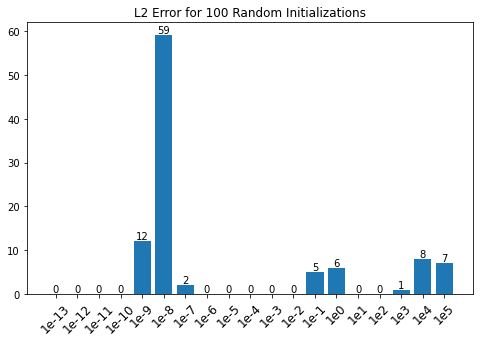

Mean of cntL2errvec: 12013.328479849615
Variance of cntL2errvec: 4267720595.8491707
Standard deviation of cntL2errvec: 65327.79344084086


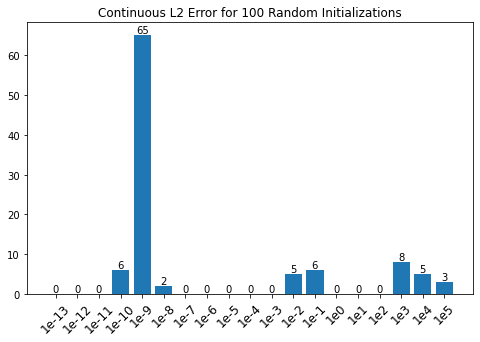

Mean of Linfvec: 24037.57574757786
Variance of Linfvec: 18297876312.781456
Standard deviation of Linfvec: 135269.6429831226


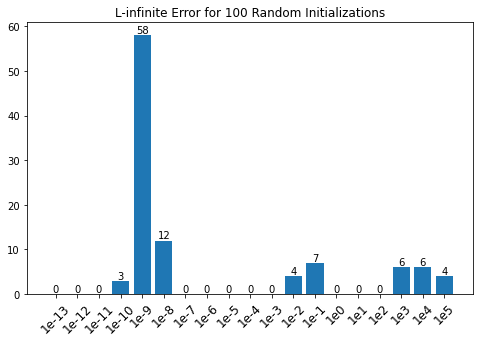

Mean of cntLinfvec: 13788.451307515596
Variance of cntLinfvec: 4183646934.929818
Standard deviation of cntLinfvec: 64681.11729809418


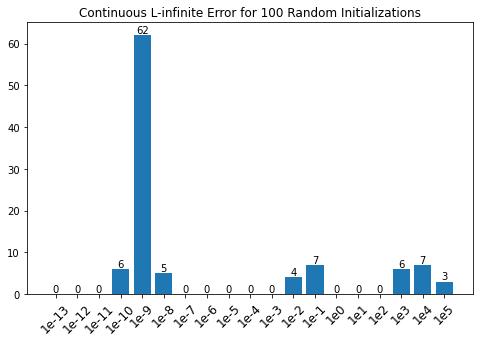

In [107]:
def makebar(array):
    binrange = np.arange(-5, 13 + 1)
    binvalvec = 1e-1**binrange
    # print(binvalvec)

    array = np.array(array)

    bardata = []

    bardata.append(np.count_nonzero(array > binvalvec[0]))

    for i in range(len(binvalvec) - 2):
        bardata.append(np.count_nonzero(np.logical_and(array <= binvalvec[i], array > binvalvec[i+1])))

    bardata.append(np.count_nonzero(array <= binvalvec[-2]))

    # print(bardata)

    xtickslabels = []
    for n in binrange:
        xtickslabels.append(f'1e{-n}')

    # print(xtickslabels)

    plt.figure(figsize=(8, 5))
    barcontainer = plt.bar(-binrange, bardata)
    plt.xticks(-binrange, xtickslabels, fontsize='large', rotation=45)
    plt.bar_label(barcontainer)
    # plt.yscale('log')


print('Mean of iterations:', np.mean(itercountvec))
print('Variance of iterations:', np.var(itercountvec))
print('Standard deviation of iterations:', np.std(itercountvec))
print('')


print('Mean of objvalvec:', np.mean(objvalvec))
print('Variance of objvalvec:', np.var(objvalvec))
print('Standard deviation of objvalvec:', np.std(objvalvec))

makebar(objvalvec)
plt.title(f'Objective Function for {numloop} Random Initializations')
plt.show()


print('Mean of L2errvec:', np.mean(L2errvec))
print('Variance of L2errvec:', np.var(L2errvec))
print('Standard deviation of L2errvec:', np.std(L2errvec))

makebar(L2errvec)
plt.title(f'L2 Error for {numloop} Random Initializations')
plt.show()


print('Mean of cntL2errvec:', np.mean(cntL2errvec))
print('Variance of cntL2errvec:', np.var(cntL2errvec))
print('Standard deviation of cntL2errvec:', np.std(cntL2errvec))

makebar(cntL2errvec)
plt.title(f'Continuous L2 Error for {numloop} Random Initializations')
plt.show()


print('Mean of Linfvec:', np.mean(Linfvec))
print('Variance of Linfvec:', np.var(Linfvec))
print('Standard deviation of Linfvec:', np.std(Linfvec))

makebar(Linfvec)
plt.title(f'L-infinite Error for {numloop} Random Initializations')
plt.show()


print('Mean of cntLinfvec:', np.mean(cntLinfvec))
print('Variance of cntLinfvec:', np.var(cntLinfvec))
print('Standard deviation of cntLinfvec:', np.std(cntLinfvec))

makebar(cntLinfvec)
plt.title(f'Continuous L-infinite Error for {numloop} Random Initializations')
plt.show()

---

In [108]:
# functions for generating propagator matrix from cheb coefficients

def mk_prop_mat(vmat, verbose = False):

    # Hamiltonian matrix
    hmat = kmat + vmat

    # eigendecomposition chebhmat
    spc, stt = nl.eigh(hmat)

    # propagator matrix
    propa = stt @ np.diag(np.exp(-1j * spc * dt)) @ np.transpose(np.conj(stt))

    if verbose:
        # check if the Hamiltonian matrix is Hermitian
        print('Check if hmat is Hermitian (should be close to 0):', nl.norm(hmat - np.conj(np.transpose(hmat))), sep='\n')

        # check if the decomposition diagonalizes chebhmat
        # if this is close to zero then
        # hmat = states @ np.diag(spec) @ np.conj(states).T
        print('Check if hmat is diagonalized (should be close to 0):', nl.norm(hmat @ stt - stt @ np.diag(spc)), sep='\n')

        # check if the eigenstates are unitary
        print('Check if stt is Unitary (should be close to 0):', nl.norm(stt @ np.conj(np.transpose(stt)) - np.eye(2 * numfour + 1)), sep='\n')
        print('')

        # check if chebhmat equal to fourHmat
        print('L2 error of hmat and fourHmat (should be close to 0):', nl.norm(hmat - fourHmat), sep='\n')
        print('L-infinite error of hmat and fourHmat (should be close to 0):', np.max(np.abs(hmat - fourHmat)), sep='\n')

        # check if chebspc equal to fourspc
        print('L2 error of spc and fourspc (should be close to 0):', nl.norm(spc - fourspc), sep='\n')
        print('L-infinite error of spc and fourspc (should be close to 0):', np.max(np.abs(spc - fourspc)), sep='\n')

        # check if chebstt equal to
        print('L2 error of stt and fourstt (should be close to 0):', nl.norm(stt - fourstt), sep='\n')
        print('L-infinite error of stt and fourstt (should be close to 0):', np.max(np.abs(stt - fourstt)), sep='\n')

    return propa

---

Lowest continuous L2 error: 3.1497627323298193e-10
Objective of lowest continuous L2 error: 1.2003904408313481e-24


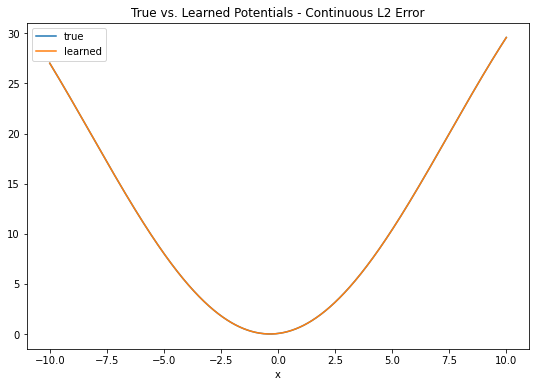

Check if hmat is Hermitian (should be close to 0):
0.0
Check if hmat is diagonalized (should be close to 0):
2.780963027869378e-13
Check if stt is Unitary (should be close to 0):
1.2375440286527686e-14

L2 error of hmat and fourHmat (should be close to 0):
5.148521464368381e-10
L-infinite error of hmat and fourHmat (should be close to 0):
1.3800793189013393e-11
L2 error of spc and fourspc (should be close to 0):
1.0075775891693759e-10
L-infinite error of spc and fourspc (should be close to 0):
4.295941380405566e-11
L2 error of stt and fourstt (should be close to 0):
6.855994258572655
L-infinite error of stt and fourstt (should be close to 0):
0.6368370717820752

Lowest objective: 4.470168776816465e-25
Continuous L2 error of lowest objective: 2.716340483092287e-09


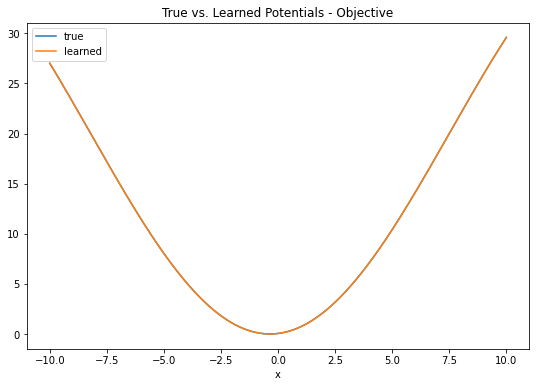

Check if hmat is Hermitian (should be close to 0):
0.0
Check if hmat is diagonalized (should be close to 0):
2.928448078049938e-13
Check if stt is Unitary (should be close to 0):
1.1737487278592914e-14

L2 error of hmat and fourHmat (should be close to 0):
3.822376150089985e-09
L-infinite error of hmat and fourHmat (should be close to 0):
8.50696664993946e-11
L2 error of spc and fourspc (should be close to 0):
8.11189902182821e-10
L-infinite error of spc and fourspc (should be close to 0):
4.037161716041737e-10
L2 error of stt and fourstt (should be close to 0):
6.855939739271276
L-infinite error of stt and fourstt (should be close to 0):
0.6367156522208094


In [109]:
# pick out the set of learned coefficients that had the smallest
# continuous L2 error of for the potential
# use these coefficients for generating results
mincntL2indx = np.argmin(cntL2errvec)
mincntL2cff = learnedcffvec[mincntL2indx]

print('Lowest continuous L2 error:', cntL2errvec[mincntL2indx])
print('Objective of lowest continuous L2 error:', objvalvec[mincntL2indx])

plt.figure(figsize=(9, 6))
plt.plot(xvec, vxvec, label='true')
plt.plot(xvec, chebtox @ mincntL2cff, label='learned')
plt.title('True vs. Learned Potentials - Continuous L2 Error')
plt.xlabel('x')
plt.legend()
plt.show()

# vmat from learned cheb cffs
vmatmincntL2cff = jaxchebtofour @ mincntL2cff

propamincntL2cff = mk_prop_mat(vmatmincntL2cff, verbose=True)

# pick out coefficients with the lowest objective
minobjindx = np.argmin(objvalvec)
minobjcff = learnedcffvec[minobjindx]

print('')
print('Lowest objective:', objvalvec[minobjindx])
print('Continuous L2 error of lowest objective:', cntL2errvec[minobjindx])

plt.figure(figsize=(9, 6))
plt.plot(xvec, vxvec, label='true')
plt.plot(xvec, chebtox @ minobjcff, label='learned')
plt.title('True vs. Learned Potentials - Objective')
plt.xlabel('x')
plt.legend()
plt.show()

# vmat from learned cheb cffs
vmatminobjcff = jaxchebtofour @ minobjcff

propaminobjcff = mk_prop_mat(vmatminobjcff, verbose=True)

**Propagate Past Training Data**

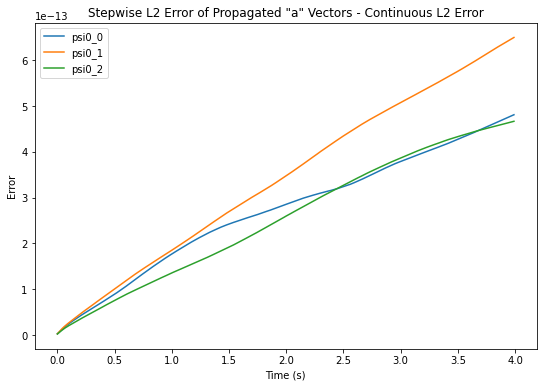

Total L2 error of amat - continuous L2 error (should be close to 0):
1.1440414645483054e-11
Total L-infinite error of amat - continuous L2 error (should be close to 0):
2.5398911745696636e-13


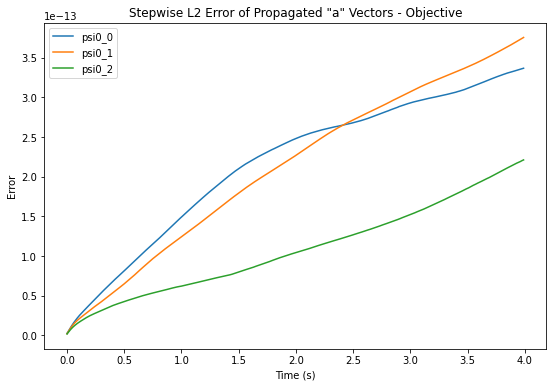

Total L2 error of amat - objective (should be close to 0):
7.127247445827588e-12
Total L-infinite error of amat - objective (should be close to 0):
1.5406676758666558e-13


In [110]:
# set how many steps for propagation
proplength = numts * 4

amattruecntL2errveclong = []
amatlearncntL2errveclong = []
stepL2errcntL2errvec = []
amattrueobjveclong = []
amatlearnobjveclong = []
stepL2errobjvec = []
# propagate system starting from initial "a" state
for thisa0 in a0vec:
    tempamattruecntL2err = [thisa0.copy()]
    tempamatlearncntL2err = [thisa0.copy()]
    tempstepL2errcntL2err = []
    tempamattrueobj = [thisa0.copy()]
    tempamatlearnobj = [thisa0.copy()]
    tempstepL2errobj = []
    for i in range(proplength):
        tempamattruecntL2err.append(fourpropa @ tempamattruecntL2err[-1])
        tempamatlearncntL2err.append(propamincntL2cff @ tempamatlearncntL2err[-1])
        tempstepL2errcntL2err.append(nl.norm(np.subtract(tempamattruecntL2err[-1], tempamatlearncntL2err[-1])))
        tempamattrueobj.append(fourpropa @ tempamattrueobj[-1])
        tempamatlearnobj.append(propaminobjcff @ tempamatlearnobj[-1])
        tempstepL2errobj.append(nl.norm(np.subtract(tempamattrueobj[-1], tempamatlearnobj[-1])))

    stepL2errcntL2errvec.append(tempstepL2errcntL2err)
    stepL2errobjvec.append(tempstepL2errobj)

    amattruecntL2errveclong.append(tempamattruecntL2err)
    amatlearncntL2errveclong.append(tempamatlearncntL2err)
    amattrueobjveclong.append(tempamattrueobj)
    amatlearnobjveclong.append(tempamatlearnobj)


plt.figure(figsize=(9, 6))
for i in range(len(stepL2errcntL2errvec)):
    thissteperrvec = stepL2errcntL2errvec[i]
    plt.plot(np.arange(proplength) * dt, thissteperrvec, label=f'psi0_{i}')

plt.title('Stepwise L2 Error of Propagated "a" Vectors - Continuous L2 Error')
plt.xlabel('Time (s)')
plt.ylabel('Error')
plt.legend()
plt.show()

print('Total L2 error of amat - continuous L2 error (should be close to 0):', nl.norm(np.subtract(amattruecntL2errveclong, amatlearncntL2errveclong)), sep='\n')
print('Total L-infinite error of amat - continuous L2 error (should be close to 0):', np.max(np.abs(np.subtract(amattruecntL2errveclong, amatlearncntL2errveclong))), sep='\n')


plt.figure(figsize=(9, 6))
for i in range(len(stepL2errobjvec)):
    thissteperrvec = stepL2errobjvec[i]
    plt.plot(np.arange(proplength) * dt, thissteperrvec, label=f'psi0_{i}')

plt.title('Stepwise L2 Error of Propagated "a" Vectors - Objective')
plt.xlabel('Time (s)')
plt.ylabel('Error')
plt.legend()
plt.show()

print('Total L2 error of amat - objective (should be close to 0):', nl.norm(np.subtract(amattrueobjveclong, amatlearnobjveclong)), sep='\n')
print('Total L-infinite error of amat - objective (should be close to 0):', np.max(np.abs(np.subtract(amattrueobjveclong, amatlearnobjveclong))), sep='\n')

---
**Propagate New Initial Wave Function**

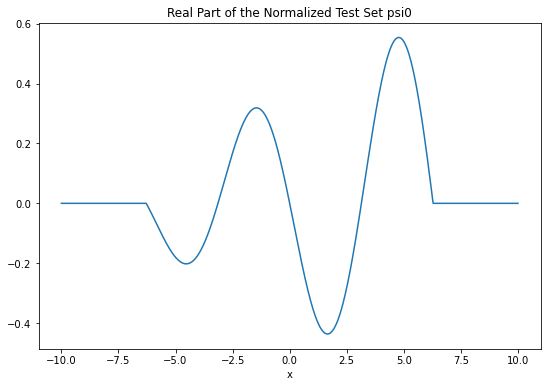

In [111]:
def testsetpsi0(z):
    mask = np.logical_and(z >= -2 * np.pi, z < 2 * np.pi)
    return ((-1 / 20) * z - 0.5) * np.sin(z * mask)

testseta0, testsetnormpsi = mka0(testsetpsi0)

plt.figure(figsize=(9, 6))
plt.plot(xvec, np.real(testsetnormpsi))
plt.title('Real Part of the Normalized Test Set psi0')
plt.xlabel('x')
plt.show()


Propagation Done


Total L2 error: 1.924613132799742e-11
Total L-infinite error: 9.751531174673463e-13


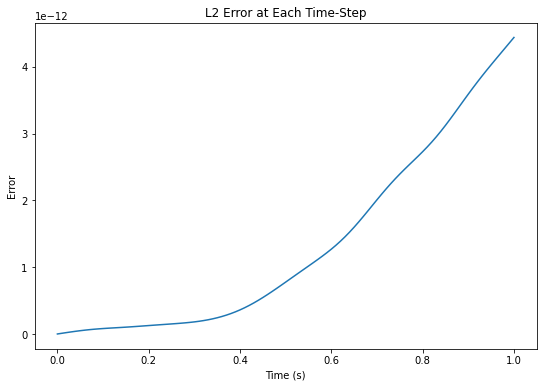

L2 error for last step: 4.440789735190781e-12


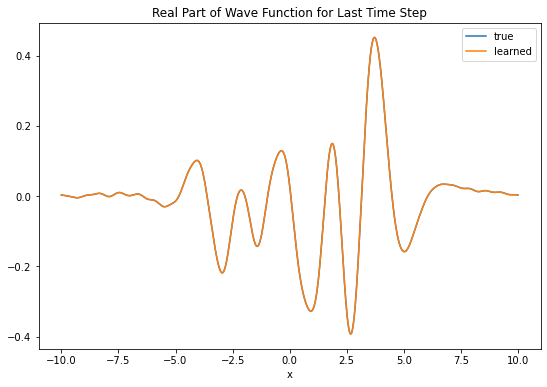

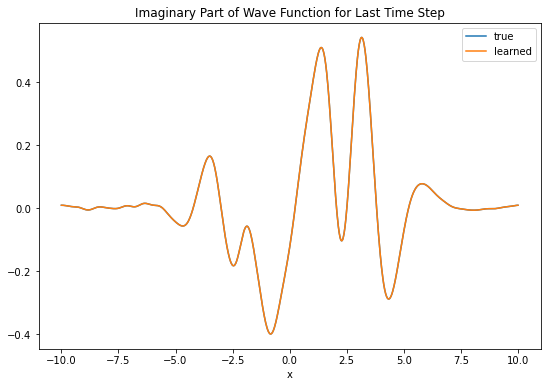

In [112]:
# propagate system starting from initial "a" state
amattesttrue = [testseta0.copy()]
amattestlearn = [testseta0.copy()]
stepL2err = [0]
for i in range(numts):
    amattesttrue.append(fourpropa @ amattesttrue[-1])
    amattestlearn.append(propaminobjcff @ amattestlearn[-1])
    # check if amattesttrue is equal to amattestlearn
    stepL2err.append(nl.norm(amattesttrue[-1] - amattestlearn[-1]))

print('')
print('Propagation Done\n')

amattesttrue = np.array(amattesttrue)
amattestlearn = np.array(amattestlearn)

print('')
print('Total L2 error:', nl.norm(amattesttrue - amattestlearn))
print('Total L-infinite error:', np.max(np.abs(amattesttrue - amattestlearn)))

plt.figure(figsize=(9, 6))
plt.plot(np.arange(numts + 1) * dt, stepL2err)
plt.title('L2 Error at Each Time-Step')
plt.xlabel('Time (s)')
plt.ylabel('Error')
plt.show()

print('L2 error for last step:', nl.norm(amattesttrue[-1] - amattestlearn[-1]))

plt.figure(figsize=(9, 6))
plt.plot(xvec, np.real(amattesttrue[-1] @ fourtox), label='true')
plt.plot(xvec, np.real(amattestlearn[-1] @ fourtox), label='learned')
plt.title('Real Part of Wave Function for Last Time Step')
plt.xlabel('x')
plt.legend()
plt.show()

plt.figure(figsize=(9, 6))
plt.plot(xvec, np.imag(amattesttrue[-1] @ fourtox), label='true')
plt.plot(xvec, np.imag(amattestlearn[-1] @ fourtox), label='learned')
plt.title('Imaginary Part of Wave Function for Last Time Step')
plt.xlabel('x')
plt.legend()
plt.show()

# # check if amattesttrue is equal to amattestlearn
# print('L2 error of amattesttrue and amattestlearn (should be close to 0):', nl.norm(amattesttrue - amattestlearn), sep='\n')
# print('L-infinite error of amattesttrue and amattestlearn (should be close to 0):', np.max(np.abs(amattesttrue - amattestlearn)), sep='\n')

**Propagate with Constant Potential + Time-Dependent Perturbation**

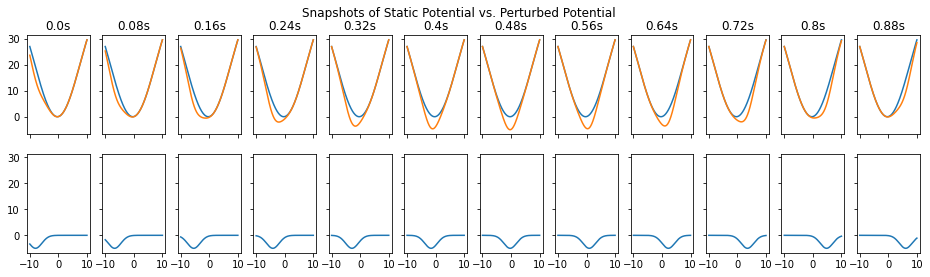

In [113]:
numsnapshots = 12
plottstep = numts // numsnapshots

def vt(x, i):
    return -5 * np.exp(-(x + 8 - (16 / numts) * i)**2 / 10)

fig, axs = plt.subplots(nrows=2, ncols=numsnapshots, sharex='all', sharey='all', figsize=(16, 4))

for i in range(numsnapshots):
    vtxvec = vt(xvec, plottstep * i)
    axs[0, i].plot(xvec, vxvec)
    axs[0, i].plot(xvec, vxvec + vtxvec)
    axs[1, i].plot(xvec, vtxvec)
    axs[0, i].set_title(f'{plottstep * i * dt}s')

fig.suptitle('Snapshots of Static Potential vs. Perturbed Potential')

plt.show()

0 of 100
10 of 100
20 of 100
30 of 100
40 of 100
50 of 100
60 of 100
70 of 100
80 of 100
90 of 100


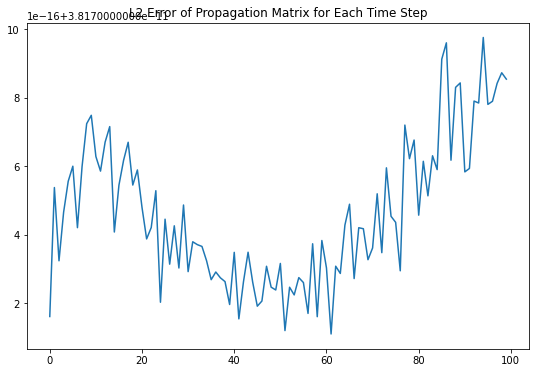

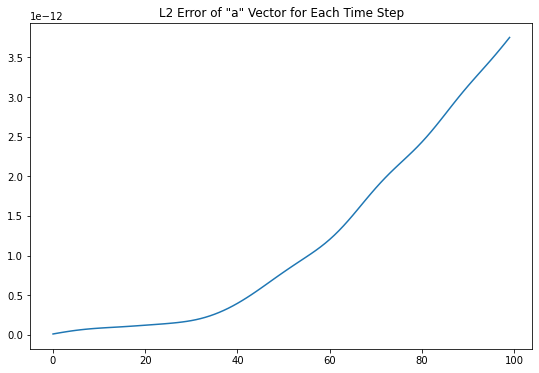

L2 error of amattimetrue and amattimelearn (should be close to 0):
1.6613558262243587e-11
L-infinite error of amattimetrue and amattimelearn (should be close to 0):
8.341010906775869e-13


In [114]:
# vmat = vmat1 + vmat2 + ... so we just need to
# compute the time-dependent part of the potential
# for each time step

# propagate system starting from initial "a" state
amattimetrue = [testseta0.copy()]
amattimelearn = [testseta0.copy()]
stepL2errtime = []
stepL2errtimeprop = []
for i in range(numts):
    if not(i % 10):
        print(f'{i} of {numts}')

    fourvtoeptime = []
    for thisfourn in range(2 * numfour + 1):
        def intgrnd(x):
            return vt(x, i) * np.exp(-1j * np.pi * thisfourn * x / a) / (2 * a)
        def rintgrnd(x):
            return intgrnd(x).real
        def iintgrnd(x):
            return intgrnd(x).imag
        fourvtoeptime.append(si.quad(rintgrnd, -a, a, limit=100)[0] + 1j * si.quad(iintgrnd, -a, a, limit=100)[0])
    vmattime = sl.toeplitz(r=fourvtoeptime, c=np.conj(fourvtoeptime))

    propatruetime = mk_prop_mat(fourvmat + vmattime)
    propalearntime = mk_prop_mat(vmatminobjcff + vmattime)

    # check if propagation matrices are close
    stepL2errtimeprop.append(nl.norm(propatruetime - propalearntime))

    amattimetrue.append(propatruetime @ amattimetrue[-1])
    amattimelearn.append(propalearntime @ amattimelearn[-1])

    stepL2errtime.append(nl.norm(amattimetrue[-1] - amattimelearn[-1]))

plt.figure(figsize=(9, 6))
plt.plot(stepL2errtimeprop)
plt.title('L2 Error of Propagation Matrix for Each Time Step')
plt.show()

plt.figure(figsize=(9, 6))
plt.plot(stepL2errtime)
plt.title('L2 Error of "a" Vector for Each Time Step')
plt.show()

amattimetrue = np.array(amattimetrue)
amattimelearn = np.array(amattimelearn)

# # check if amattesttrue is equal to amattestlearn
print('L2 error of amattimetrue and amattimelearn (should be close to 0):', nl.norm(amattimetrue - amattimelearn), sep='\n')
print('L-infinite error of amattimetrue and amattimelearn (should be close to 0):', np.max(np.abs(amattimetrue - amattimelearn)), sep='\n')